<a href="https://colab.research.google.com/github/linwanlu/CNN/blob/main/fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 物件偵測（anchor based）

## anchor based
可參考：https://cloud.tencent.com/developer/article/2294786
    
    
假設我們要從圖中，把物體框住。我們可以先設定stride=16在圖上點出錨點（anchor）。以每一個錨點為中心，對每一個中心點設計多個尺寸的方框，再對每種尺寸的方框進行多種變形（固定面積，更改長寬比），形成新的框。

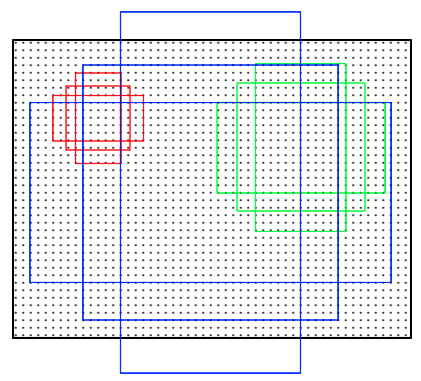

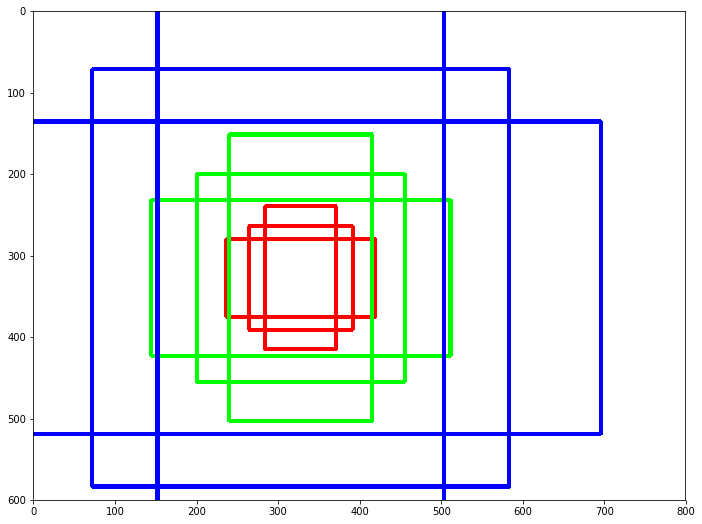


# Faster RCNN

### 論文：https://arxiv.org/abs/1506.01497
### 參考：https://blog.csdn.net/weixin_42310154/article/details/119889682


---


## 背景
先前的物件偵測方法（如R-CNN和Fast R-CNN）先找出「可能有物件的區域」（叫做區域提議），然後再進一步確認這些區域裡的物件是什麼。但是這個過程很慢，尤其是在找區域的時候很耗時間。

## 貢獻
* 提出了一個叫做**區域提議網路（RPN）**的新方法，讓電腦用神經網路來自動找區域。

* 作者團隊把這個區域提議的部分和物件分類的部分放進同一個網路裡，讓這兩部分可以共享計算結果，節省時間。

## 效果
* Faster R-CNN，可以在每秒處理5張圖片的情況下，準確地找到物件，比先前的方法快

* 在一些常用的測試資料（像PASCAL VOC和MS COCO）中，這個方法表現得非常好，不僅速度快，準確性也比以前的方法高

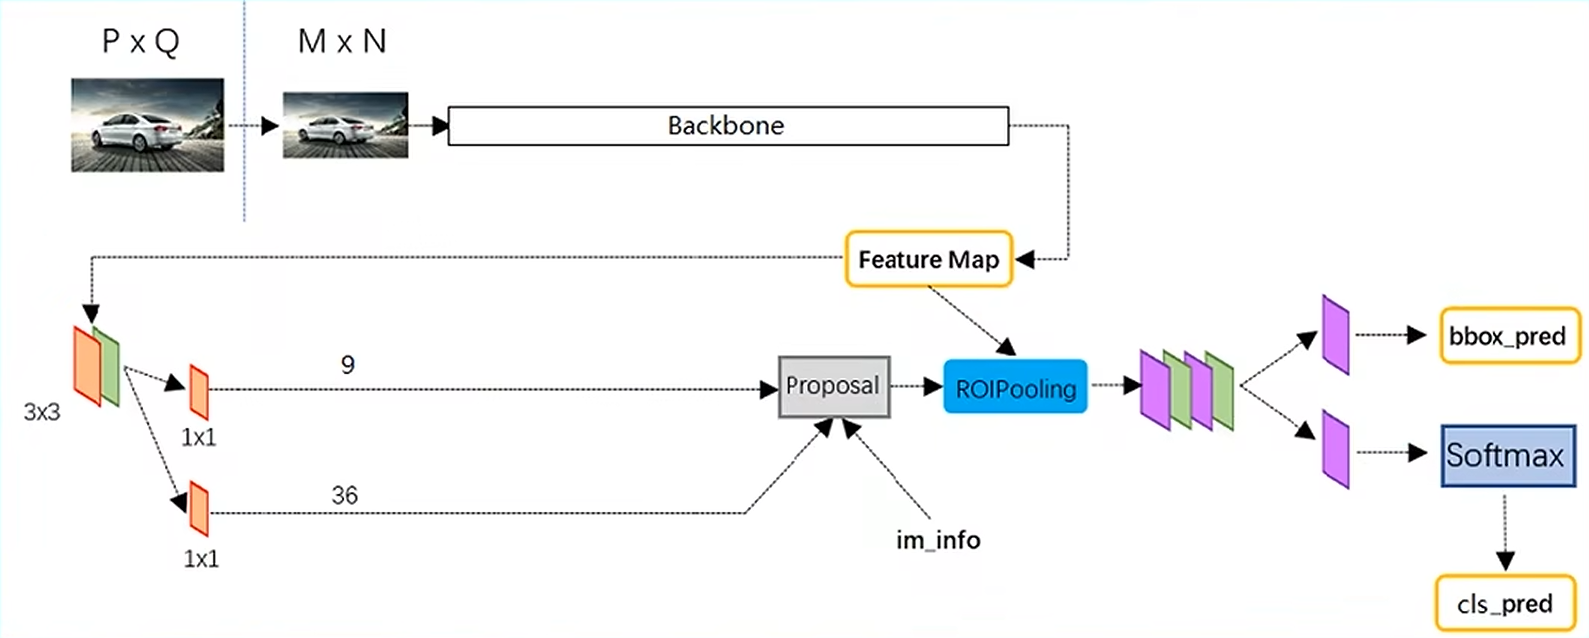

# Loss function

#### RPN(Region Proposal Network)
區域候選網路，用來生成候選框。在這邊的有兩個部分的任務。  
* 分類：判斷所有預設anchor是positive還是negative  
* bounding box regression：修正anchor得到比較準確的proposals

Faster RCNN是two-stage檢測器，訓練要分成兩個部分進行，一個是訓練RPN網絡，一個是訓練後面的分類網絡。

* RPN網路= 特徵提取conv層（下面簡稱共享conv層） + RPN特有層（3x3卷積、1x1卷積等）
* Faster RCNN網路= 共享conv層+ Faster RCNN特有層（全連接層）



---

網絡訓練有兩個Loss：

* Lcls：softmax loss，用於分類anchors屬於前景還是背景（也有說用二分類交叉熵Loss的）
* Lreg：smooth L1 loss，用於修正anchor框，前面乘了一個pi*表示只回歸有目標的框
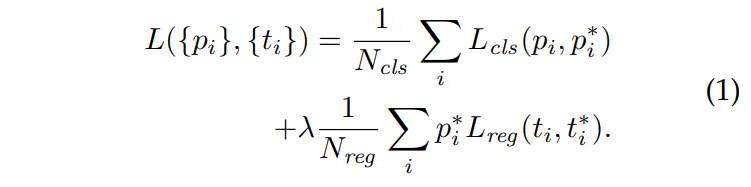

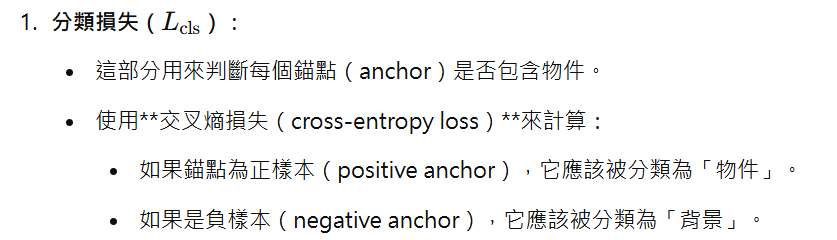

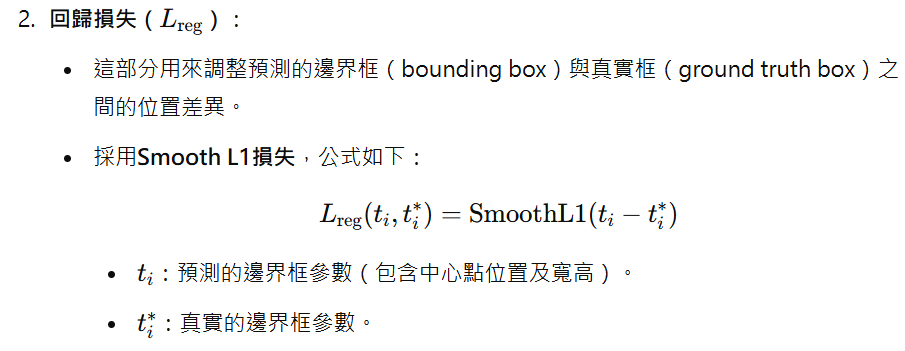

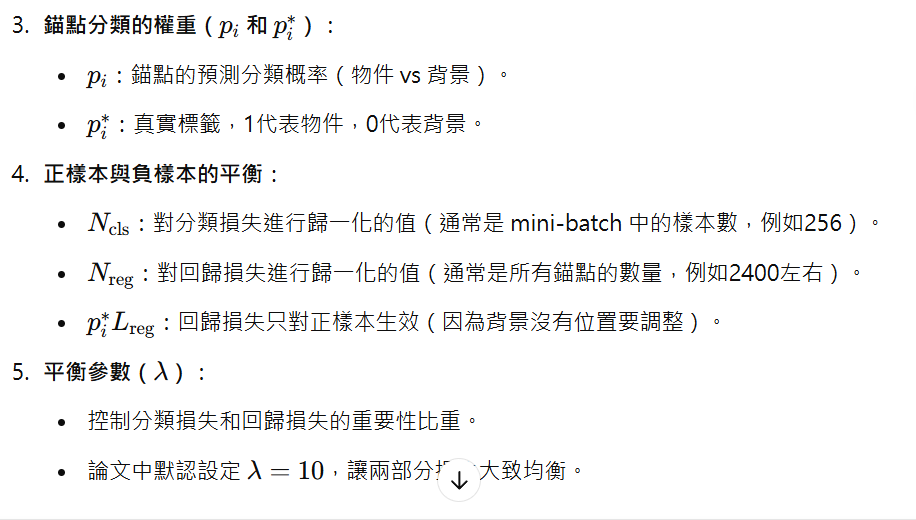

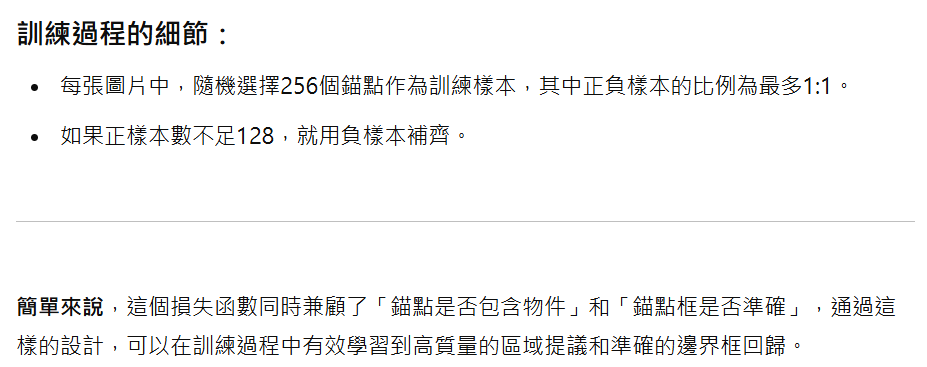

In [ ]:
import torch
import torch.nn as nn

class RPNLoss(nn.Module):
    def __init__(self, lambda_value=10.0):
        super(RPNLoss, self).__init__()
        self.lambda_value = lambda_value
        self.cls_loss_fn = nn.CrossEntropyLoss()  # 分類損失 (兩類：物件 or 背景)
        self.reg_loss_fn = nn.SmoothL1Loss(reduction='sum')  # 邊界框回歸損失

    def forward(self, cls_scores, cls_targets, reg_preds, reg_targets, positive_mask):
        """
        Args:
            cls_scores: 預測的分類分數 (batch_size, num_anchors, 2)
            cls_targets: 真實的分類標籤 (batch_size, num_anchors) [0: 背景, 1: 物件]
            reg_preds: 預測的邊界框參數 (batch_size, num_anchors, 4)
            reg_targets: 真實的邊界框參數 (batch_size, num_anchors, 4)
            positive_mask: 是否為正樣本的遮罩 (batch_size, num_anchors) [1: 正樣本, 0: 負樣本]

        Returns:
            total_loss: 加權的總損失
        """
        # 分類損失
        cls_loss = self.cls_loss_fn(cls_scores.view(-1, 2), cls_targets.view(-1))

        # 回歸損失（只對正樣本計算）
        positive_mask = positive_mask.view(-1).bool()
        reg_loss = self.reg_loss_fn(reg_preds.view(-1, 4)[positive_mask],
                                    reg_targets.view(-1, 4)[positive_mask])

        # 歸一化
        cls_loss = cls_loss / cls_scores.shape[0]  # 使用 batch_size 歸一化
        reg_loss = reg_loss / positive_mask.sum()  # 正樣本數歸一化

        # 總損失
        total_loss = cls_loss + self.lambda_value * reg_loss
        return total_loss


In [ ]:
# 使用方法
# 假設的輸入數據
batch_size, num_anchors = 2, 9
cls_scores = torch.randn(batch_size, num_anchors, 2)  # 分類分數
cls_targets = torch.randint(0, 2, (batch_size, num_anchors))  # 分類真實標籤
reg_preds = torch.randn(batch_size, num_anchors, 4)  # 邊界框預測
reg_targets = torch.randn(batch_size, num_anchors, 4)  # 邊界框真實標籤
positive_mask = torch.randint(0, 2, (batch_size, num_anchors))  # 正樣本遮罩

# 計算損失
loss_fn = RPNLoss()
loss = loss_fn(cls_scores, cls_targets, reg_preds, reg_targets, positive_mask)
print(f"Total Loss: {loss.item()}")


# **實作程式**

參考：https://blog.csdn.net/weixin_44791964/article/details/105739918

In [ ]:
#!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import math
from torch.hub import load_state_dict_from_url

## 一、預測

### 1. 骨幹網路介紹


Fater-RCNN可以採用多種骨幹特徵題庫網路，這邊以Resnet為例。

Faster-Rcnn對輸入進來的圖片尺寸沒有固定，但是一般會把輸入進來的圖片短邊固定成600，如輸入一張1200x1800的圖片，會把圖片不失真的resize到600x900上。

Faster-RCNN的主幹特徵提取網路部分只包含了長寬壓縮了四次的內容，第五次壓縮後的內容在ROI中使用。即Faster-RCNN在主幹特徵擷取網路所使用的網路層如圖所示。

以輸入的圖片為600x600為例，shape變化如下：
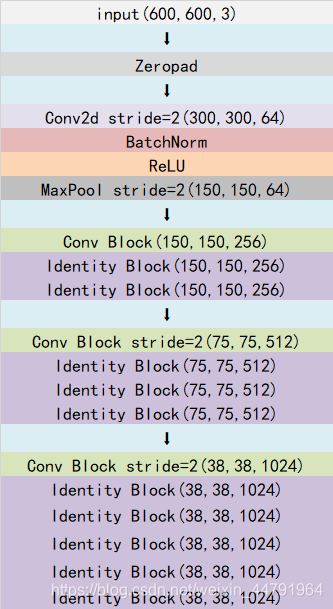

最後一層的輸出就是公用特徵層。

在程式碼裡面，我們使用resnet50()函數來取得resnet50的公用特徵層。

其中features部分為公用特徵層，classifier部分為第二階段所用到的分類器。


In [ ]:
# 定義 Bottleneck Block，適用於 ResNet-50、101 和 152
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        # Bottleneck 的通道擴展比例為 4
        self.expansion = 4
        # 第一層 1x1 卷積，減少計算量
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels) # 批次正規化
        # 第二層 3x3 卷積，提取特徵
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
         # 第三層 1x1 卷積，恢復到擴展後的通道數
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU() # 激活函數
        # 用於處理輸入與輸出的維度不匹配的情況
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x # 保存輸入以便加入 Shortcut

        # 通過第一層卷積
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # 通過第二層卷積
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        # 通過第三層卷積
        x = self.conv3(x)
        x = self.bn3(x)

        # 如果需要下採樣，調整 Shortcut 的形狀
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # 將輸出與 Shortcut 相加，實現 Residual 連接
        x += identity
        x = self.relu(x) # 再次通過激活函數
        return x

# 定義 ResNet 架構
class ResNet(nn.Module): #[3,4,6,3]
    def __init__(self, block, layers, image_channels, num_classes):
        """
        假設輸入的圖片是[600x600x3]

        """
        super(ResNet, self).__init__()
        self.in_channels = 64  # 第一層的輸出通道數

        # 初始卷積層（輸入影像 -> 特徵圖）
        # [600x600x3]->[300x300x64]
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # [300x300x64]->[150,150,64]
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0,ceil_mode=True)

        # ResNet layers
        # ResNet 的四個主要層，每層由多個 Bottleneck Blocks 組成
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        # [75x75x512]->[38x38x1024] 到這裡可以得到一個共享特徵層
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        # self.layer4被用在classifier模型中
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AvgPool2d(7)
        # 全連接層，輸出為分類的類別數
        self.fc = nn.Linear(512*4, num_classes)

        # 初始化所有層的參數
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
          # 初始卷積層
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResNet 的四個主要層
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

         # 平均池化與全連接層
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)  # 展平
        x = self.fc(x)
        return x

     # 定義生成 ResNet 層的方法
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # 如果需要改變維度，設置下採樣
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                         stride=stride),
                                               nn.BatchNorm2d(out_channels*4))

        # 添加第一個 Bottleneck Block
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4  # 更新 in_channels

        # 添加剩餘的 Bottleneck Blocks
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) #256 -> 64, 64*4=(256) again

        return nn.Sequential(*layers)

def resnet50(pretrained=False, image_channels=3, num_classes=1000):
    model = ResNet(Bottleneck, [3,4,6,3])
    if pretrained:
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/resnet50-19c8e357.pth", model_dir="./model_data")
        model.load_state_dict(state_dict)

    #抓取特徵提取部分，從conv1到model.layer3,最終獲得一個[38x38x1024]的特徵層
    features = list([model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3])
    features = nn.Sequential(*features)

    #抓取分類部分，從model.layer4到model.avgpool
    classifier = list([model.layer4, model.avgpool])
    classifier = nn.Sequential(*classifier)

    return features, classifier

### 2. Proposal建議框

Feature Map將進行兩個動作，一個是和ROIPooling結合使用、另一個是進行一次3x3的捲積後，進行一個18通道的1x1卷積，還有一個36通道的1x1卷積。

在Faster-RCNN中，num_priors也就是先驗框的數量就是9，所以兩個1x1卷積的結果其實就是：

* 9 x 4的捲積用來預測公用特徵層上 每一個網格點上每一個先驗框的變化。（為什麼說是變化情況呢，這是因為Faster-RCNN的預測結果需要結合先驗框以獲得預測框，預測結果就是先驗框的變化。）

* 9 x 2的捲積用來預測公用特徵層上 每一個網格點上 每一個預測框內部是否包含了物體，序號為1的內容為包含物體的機率。

當我們輸入的圖片的shape是600x600x3的時候，公用特徵層的shape就是38x38x1024，相當於把輸入進來的圖像分割成38x38的網格，然後每個網格存在9個先驗框，這些先驗框有不同的大小，在圖像上密密麻麻。

* 9 x 4的捲積的結果會對這些先驗框進行調整，得到一個新的框。
* 9 x 2的捲積會判斷上述所得的新框是否包含物體。

到這裡我們可以得到了一些有用的框框，這些框會利用9 x 2的捲積來判斷是否有物體。

到此位置還只是粗略的一個框的獲取，也就是一個建議框。然後我們會在建議框框裡面繼續找東西。

In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(
            self,
            in_channels = 512,
            mid_channels = 512,
            ratios = [0.5, 1, 2], #先驗框的寬高比（如 [0.5, 1, 2] 分別對應高寬比長方形、正方形、寬長方形）。
            anchor_scales = [8, 16, 32],
            feat_stride = 16,
            mode = "training",
    ):
        super(RegionProposalNetwork, self).__init__()

        # 生成基礎先驗框，[9,4]
        """
        * 使用提供的比例和尺度生成基礎的 先驗框模板，形狀為 [9, 4]（9 表示 3 種比例 * 3 種尺度）。
        * 每個先驗框由 4 個數值組成 [x_min, y_min, x_max, y_max]，定義框的左上角和右下角。

        """
        self.anchor_base = generate_anchor_base(
            anchor_scales = anchor_scales, ratios = ratios
        )
        n_anchor = self.anchor_base.shape[0]


        # 3x3卷積，特徵整理
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1) # kernel size, stride,  padding

        # 分類層（self.score)：輸出每個先驗框內是否包含物體的分類分數
        # 輸出通道數為 n_anchor * 2，即每個先驗框 2 個分類（有物體/無物體）。
        self.score = nn.Conv2d(mid_channels, n_anchor * 2 ,1,1,0)

        # 回歸層（self.loc)：輸出每個先驗框的 4 個回歸偏移量，用於微調先驗框位置
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)

        self.feat_stride = feat_stride

        # 使用 ProposalCreator 解碼建議框並進行 非極大值抑制
        self.proposal_layer = ProposalCreator(mode)

        #初始化卷積層的權重，均值為 0，標準差為 0.01
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)


    def forward(self, x, img_size, scale = 1.0):
        n, _, h, w = x.shape
        # 3x3卷積和 ReLU ，特徵整合
        x = F.relu(self.conv1(x))

        # 回歸輸出（位置調整
        rpn_locs = self.loc(x)
            # 透過 permute 調整維度(n,h,w,c)=(n,50,50,36)，並展平為 [n, num_anchors, 4]
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        # 分類輸出（是否包含物體）
        rpn_scores = self.score(x)
            #透過 permute 和 view 展平為 [n, num_anchors, 2]
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous().view(n, -1, 2)

        # Softmax機率計算，每個先驗框只有兩個判斷結果（有物體和沒物體）
        rpn_softmax_scores = F.softmax(rpn_scores, dim=-1)
        rpn_fg_scores = rpn_softmax_scores[:, :, 1].contiguous() # rpn_softmax_scores[:, :, 1] 為 有物體的機率
        rpn_fg_scores = rpn_fg_scores.view(n, -1)


### 3. Proposal建議框的解碼



用於從 RPN（Region Proposal Network）的輸出中生成候選框（Region Proposals）

初始化 (__init__)
1. 模式設置 (self.mode)
mode 決定該模組處於訓練或推理模式：
* 訓練模式：保留更多建議框，用於學習。
* 推理模式：保留較少但更準確的建議框。
2. 非極大值抑制的 IoU 閾值 (self.nms_iou) ,用於控制框的重疊程度。  
預設值是 0.7：
當兩個框的 IoU 超過 0.7 時，只保留得分更高的框。
3. 建議框數量
訓練和推理模式下，分別設置：
* NMS 前的框數量（n_train_pre_nms, n_test_pre_nms）：篩選前保留的框數。
* NMS 後的框數量（n_train_post_nms, n_test_post_nms）：NMS 後的最終框數。
4. 最小框大小 (self.min_size)
用於過濾寬高小於 min_size 的框，防止生成過小的建議框。

In [ ]:
class ProposalCreator():
    def __init__(
        self,
        mode,
        nms_iou             = 0.7,
        n_train_pre_nms     = 12000,
        n_train_post_nms    = 600,
        n_test_pre_nms      = 3000,
        n_test_post_nms     = 300,
        min_size            = 16

    ):
        self.mode=mode
        self.nms_iou=nms_iou
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score, anchor, img_size, scale=1.0):
        if self.mode == "training":
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        anchor = torch.from_numpy(anchor)
        if loc.is_cuda:
            anchor = anchor.cuda()

        # 將RPN網路預測結果轉化成建議框
        roi = loc2bbox(anchor, loc)
        # 限制建議框範圍
        roi[:, [0, 2]] = torch.clamp(roi[:, [0, 2]], min = 0, max = img_size[1])
        roi[:, [1, 3]] = torch.clamp(roi[:, [1, 3]], min = 0, max = img_size[0])
        #過濾過小的框
        min_size = self.min_size * scale
        keep = torch.where(((roi[:, 2] - roi[:, 0]) >= min_size) & ((roi[:, 3] - roi[:, 1]) >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        # 根據得分排序，取出建议框
        order = torch.argsort(score, descending=True)
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]
        score = score[order]

        # 非極大值抑制（NMS）
        keep = nms(roi, score, self.nms_iou)
        keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi


### 4. 對Proposal建議框加以利用（RoiPoolingConv）

In [ ]:
class Resnet50RoIHead(nn.Module):
    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super(Resnet50RoIHead, self).__init__()
        self.classifier = classifier
        self.cls_loc = nn.Linear(2048, n_class * 4)
        self.score = nn.Linear(2048, n_class)
        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)
        self.roi = RoIPool((roi_size, roi_size), spatial_scale)

    def forward(self, x, rois, roi_indices, img_size):
        n, _, _, _ = x.shape
        if x.is_cuda:
            roi_indices = roi_indices.cuda()
            rois = rois.cuda()
        # 將候選框映射到特徵圖
        rois_feature_map = torch.zeros_like(rois)
        rois_feature_map[:, [0, 2]] = rois[:, [0, 2]] / img_size[1] * x.size()[3]
        rois_feature_map[:, [1, 3]] = rois[:, [1, 3]] / img_size[0] * x.size()[2]

        #合併候選框與其對應的批次索引，形成 RoI Pooling 的輸入
        indices_and_rois = torch.cat([roi_indices[:, None], rois_feature_map], dim=1)

        # RoI Pooling
        pool = self.roi(x, indices_and_rois)

        # 特徵提取與展平
        fc7 = self.classifier(pool)
        fc7= fc7.view(fc7.size(0), -1)

        # 回歸與分類
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)

        # 調整形狀
        roi_cls_locs = roi_cls_locs.view(n, -1, roi_cls_locs.size(1))
        roi_scores = roi_scores.view(n, -1, roi_scores.size(1))

        # roi_cls_locs：每個候選框的回歸偏移量，用於微調框的位置。
        # roi_scores：每個候選框的分類得分，用於選擇最終的框。
        return roi_cls_locs, roi_scores



## 二、訓練

### 函數定義

In [ ]:
# 計算兩組框之間的 IoU（Intersection over Union）
def bbox_iou(bbox_a, bbox_b):
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        print(bbox_a, bbox_b)
        raise IndexError
    #交集的左上角座標
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    #交集的右下角座標
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])
    #交集的面積，當 tl < br 時才有效
    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    #計算每組框的面積
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)

    #輸出一個形狀為 (𝑁,𝑀)的矩陣，其中每個元素表示框𝑎和框𝑏的IoU
    return area_i / (area_a[:, None] + area_b - area_i)



# 計算源框到目標框的回歸偏移量
def bbox2loc(src_bbox, dst_bbox):
    width = src_bbox[:, 2] - src_bbox[:, 0]
    height = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_x = src_bbox[:, 0] + 0.5 * width
    ctr_y = src_bbox[:, 1] + 0.5 * height

    base_width = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_height = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_x = dst_bbox[:, 0] + 0.5 * base_width
    base_ctr_y = dst_bbox[:, 1] + 0.5 * base_height

    eps = np.finfo(height.dtype).eps
    width = np.maximum(width, eps)
    height = np.maximum(height, eps)

    dx = (base_ctr_x - ctr_x) / width
    dy = (base_ctr_y - ctr_y) / height
    dw = np.log(base_width / width)
    dh = np.log(base_height / height)

    loc = np.vstack((dx, dy, dw, dh)).transpose()
    return loc

### 為 Faster R-CNN 的 RPN 訓練生成目標框（target）

In [ ]:
# 生成 RPN 訓練所需的目標框和標籤
class AnchorTargetCreator(object):
    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor):
        # 計算每個先驗框與真實框的 IoU，生成標籤
        argmax_ious, label = self._create_label(anchor, bbox)
        #如果存在正樣本，計算偏移量
        if (label > 0).any():
            loc = bbox2loc(anchor, bbox[argmax_ious])
            return loc, label
        else:
            return np.zeros_like(anchor), label


    # 計算每個先驗框與真實框的 IoU，並獲取最大 IoU 和對應的真實框索引
    def _calc_ious(self, anchor, bbox):
        ious = bbox_iou(anchor, bbox)

        if len(bbox)==0:
            return np.zeros(len(anchor), np.int32), np.zeros(len(anchor)), np.zeros(len(bbox))

        # 每一個先驗框對應的真實框
        argmax_ious = ious.argmax(axis=1)
        # 每一個真實框對應的最大 IoU
        max_ious =  np.max(ious, axis=1)
        # 每一個真實框對應的先驗框
        gt_argmax_ious = ious.argmax(axis=0)

        # 確保每個真實框都存在對應的先驗框
        for i in range(len(gt_argmax_ious)):
            argmax_ious[gt_argmax_ious[i]] = i

        return argmax_ious, max_ious, gt_argmax_ious


    #根據 IoU 和閾值生成標籤
    def _create_label(self, anchor, bbox):
        """
        正樣本=1
        負樣本=0
        無樣本=-1
        初始化為無樣本
        """
        label = np.empty((len(anchor),), dtype=np.int32)
        label.fill(-1)

        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox)

        """
        設置正負樣本：
        IoU < neg_iou_thresh -> 負樣本。
        IoU >= pos_iou_thresh -> 正樣本。
        保證每個真實框至少有一個對應的正樣本。
        """
        label[max_ious < self.neg_iou_thresh] = 0
        label[max_ious >= self.pos_iou_thresh] = 1
        if len(gt_argmax_ious)>0:
            label[gt_argmax_ious] = 1

        """
        平衡正負樣本數量：
            * 限制正樣本數量不超過總樣本的 50%。
            * 確保正負樣本總數為 n_sample，多餘的標記為 -1（忽略）。
        """
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # 確保總數量：n_sample
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label



#### Roi網路的訓練


In [ ]:
class ProposalTargetCreator(object):
    def __init__(self, n_sample=128, pos_ratio=0.5, pos_iou_thresh=0.5, neg_iou_thresh_high=0.5, neg_iou_thresh_low=0):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_high = neg_iou_thresh_high
        self.neg_iou_thresh_low = neg_iou_thresh_low

    def __call__(self, roi, bbox, label, loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        # 合併候選框和真實框
        roi = np.concatenate((roi.detach().cpu().numpy(), bbox), axis=0)
        # 計算建議框和真實框的重合度，IoU
        iou = bbox_iou(roi, bbox)

        if len(bbox)==0:
            gt_assignment = np.zeros(len(roi), np.int32)
            max_iou = np.zeros(len(roi))
            gt_roi_label = np.zeros(len(roi))
        else:
            # 對應的真實框索引
            gt_assignment = iou.argmax(axis=1)
            # 對應的最大 IoU
            max_iou = iou.max(axis=1)
            # 每個候選框對應真實框的標籤，+1 是為了區分背景（背景標籤為 0）
            gt_roi_label = label[gt_assignment] + 1


        #選擇正樣本
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(self.pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

        #選擇負樣本
        neg_index = np.where((max_iou < self.neg_iou_thresh_high) & (max_iou >= self.neg_iou_thresh_low))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

        #合併正負樣本
        keep_index = np.append(pos_index, neg_index)
        sample_roi = roi[keep_index]
        if len(bbox)==0:
            return sample_roi, np.zeros_like(sample_roi), gt_roi_label[keep_index]

        #計算回歸偏移量
        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = (gt_roi_loc / np.array(loc_normalize_std, np.float32))

        gt_roi_label = gt_roi_label[keep_index]
        #設置負樣本標籤為 0（背景）
        gt_roi_label[pos_roi_per_this_image:] = 0


        """
        1. sample_roi：選擇的候選框，形狀為(n_sample, )。
        2. gt_roi_loc：對應的回歸偏移量，形狀為(n_sample, 4)。
        3. gt_roi_label：對應的標籤，形狀為(n_sample,)

        """
        return sample_roi, gt_roi_loc, gt_roi_label